In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manojbhadu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")  


In [3]:
train['reviews']

0        This book was very informative, covering all a...
1        I am already a baseball fan and knew a bit abo...
2        I didn't like this product it smudged all unde...
3        I simply love the product. I appreciate print ...
4        It goes on very easily and makes my eyes look ...
                               ...                        
49995                         it does not work((((((((((((
49996    Really worthless, loud motor with absolutely n...
49997    Don't waste your money on this. It does nothin...
49998    Product does not remove ear wax. No suction, j...
49999    If you wear hearing aids these are great for r...
Name: reviews, Length: 50000, dtype: object

In [4]:
def convert_to_lower(text):
    # return the reviews after convering then to lowercase
    lower_text = text.copy()
    for i in range(len(text)):
        lower_text[i] = text[i].lower()
    return lower_text

In [5]:
def remove_punctuation(text):
    #stop_words = set(stopwords.words('english'))
    without_punctuation_text  = text.copy()
    for i in range(len(text)):
        without_punctuation_text[i] = [w for w in text[i] if w.isalpha()]
    return without_punctuation_text

In [6]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    without_stopwords_text  = text.copy()
    for i in range(len(text)):
        without_stopwords_text[i] = [w for w in text[i] if not w in stop_words]
    return without_stopwords_text

In [7]:
def perform_tokenization(text):
    tokenize_text = text.copy()
    for i in range(len(text)):
        tokenize_text[i] = nltk.word_tokenize(text[i])
    return tokenize_text

In [8]:
def get_dicts(train):
    reviews = train["reviews"]
    reviews = convert_to_lower(reviews)
    reviews = perform_tokenization(reviews)
    reviews = remove_punctuation(reviews)
    reviews = remove_stopwords(reviews)
    
    words = []
    for sent in reviews:
        for word in sent:
            words.append(word)
            
    #for phrase in test:
    #for word in phrase:
    #words.append(word)
            
    words.sort()
    words = set(words)
    word_to_index = {}
    word_to_index['<PAD>'] = 0
    word_to_index['<UNK>'] = 1
    for i, word in enumerate(words):
        word_to_index[word] = i  + 2
        
    #index_to_word = {index:word for (word, index) in word_to_index.items()}
    
    return word_to_index

In [9]:
word_to_index = get_dicts(train)

In [10]:
def encode_data(text,word_to_index):
    encoded_text = []
    for phrase in text:
        tokenized_format = []
        for word in phrase:
            try:
                index = word_to_index[word]
                tokenized_format.append(index)
            except KeyError:
                index = word_to_index['<UNK>']
                tokenized_format.append(index)
            
        encoded_text.append(tokenized_format)
    return encoded_text

In [11]:
MAX_LENGTH = 60

In [12]:
def perform_pedding(data):
    
    data = pad_sequences(data,maxlen=MAX_LENGTH,padding='post')
    return data

In [13]:
def preprocess_data(data,word_to_index):
    reviews = data["reviews"]
    reviews = convert_to_lower(reviews)
    reviews = perform_tokenization(reviews)
    reviews = remove_punctuation(reviews)
    reviews = remove_stopwords(reviews)
    reviews = encode_data(reviews,word_to_index)
    reviews = perform_pedding(reviews)
    return reviews

In [14]:
preprocessed_reviews = preprocess_data(train,word_to_index)

In [15]:
preprocessed_test_reviews = preprocess_data(test,word_to_index)

In [16]:
def softmax_activation(x):
    exp_x = np.exp(x)
    return exp_x/np.sum(exp_x)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Activation
from keras.optimizers import Adam

In [18]:
class NeuralNet:

    def __init__(self, reviews, ratings):

        self.reviews = reviews
        self.ratings = ratings



    def build_nn(self):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.model = Sequential()
        MAX_LENGTH = 60
        self.model.add(InputLayer(input_shape=(MAX_LENGTH, )))
        self.model.add(Dense(5,activation='softmax'))
        self.model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
        self.model.summary()
    def train_nn(self,batch_size,epochs):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        y_train = tf.keras.utils.to_categorical(self.ratings,num_classes=5)
        self.history = self.model.fit(self.reviews, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
        

    def predict(self, reviews):
        # return a list containing all the ratings predicted by the trained model
        y_pred = self.model.predict(reviews)
        pred1 = []
        for i in range(len(y_pred)):
            pred1.append(np.argmax(y_pred[i])+1)
        return pred1

In [135]:
train_rating_list = train['ratings'].to_list()
Y = [str(i-1) for i in train_rating_list]

In [149]:
M = NeuralNet(preprocessed_reviews,Y)
M.build_nn()
M.train_nn(64,15)
y_pred = M.predict(preprocessed_test_reviews)


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 5)                 305       
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 1s 2ms/step - loss: 865.8192 - accuracy: 0.4806 - val_loss: 178.5734 - val_accuracy: 0.4754
Epoch 2/15
625/625 [==============================] - 1s 1ms/step - loss: 50.6691 - accuracy: 0.4917 - val_loss: 22.9362 - val_accuracy: 0.5664
Epoch 3/15
625/625 [==============================] - 1s 1ms/step - loss: 13.4519 - accuracy: 0.4945 - val_loss: 17.8044 - val_accuracy: 0.5405
Epoch 4/15
625/625 [==============================] - 1s 2ms/step - loss: 11.8856 - accuracy: 0.4931 - val_loss: 12.6054 - val_accuracy: 0.4592
Epoch 5/15
625/625 [==============================] - 1s 1ms/step - los

In [150]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
Accuracy = accuracy_score(test['ratings'],y_pred)
Classification_report = classification_report(test['ratings'],y_pred,target_names=['1','2','3','4','5'])
cm  = confusion_matrix(test['ratings'],y_pred)

In [146]:
Accuracy

0.5698

In [147]:
print("Classification Report : \n",Classification_report)

Classification Report : 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00      1271
           2       0.09      0.01      0.02       630
           3       0.00      0.00      0.00       911
           4       0.16      0.01      0.01      1404
           5       0.58      0.98      0.73      5784

    accuracy                           0.57     10000
   macro avg       0.17      0.20      0.15     10000
weighted avg       0.36      0.57      0.42     10000



<AxesSubplot:>

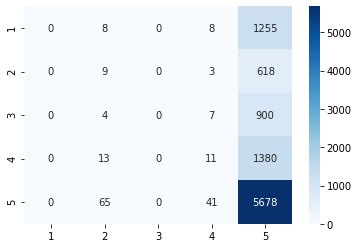

In [148]:
import seaborn as sns
sns.heatmap(cm,cmap="Blues",annot=True,fmt='.4g',xticklabels=['1','2','3','4','5'],yticklabels=['1','2','3','4','5'])


In [151]:
tried_examples = [['I like it but dont think I would buy again.'], ['Nice looking cleaner but way smaller than 2 liters. Not as advertised.'],['Total waste of money, I used all 10 of these and got 0 results from it.']] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(tried_examples, columns = ['reviews']) 

In [152]:
df

,reviews
0,I like it but dont think I would buy again.
1,Nice looking cleaner but way smaller than 2 li...
2,"Total waste of money, I used all 10 of these a..."


In [153]:
pre_tried_examples = preprocess_data(df,word_to_index)
M.predict(pre_tried_examples)

[1, 3, 3]